In [61]:
import librosa
import os, gc
import numpy as np
import random
import itertools

from sklearn import svm
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb

import matplotlib.pyplot as plt

from nltk.cluster import KMeansClusterer, euclidean_distance, cosine_distance

In [2]:
PROJECT_PATH='/home/hmenn/Workspace/CSE455_MachineLearning_2018/Final_MusicClassification'

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues, figsize=(6,6)):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [4]:
def extractMfccFeature(_path=None, _offset=12, _duration=6):
    try:
        # returns signal and sample rate
        signal, sr = librosa.load(path=_path, offset=_offset, duration=_duration)
                
        mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=20)
        l = mfccs.shape[1]
        mfccs = mfccs[:, int(0.2 * l):int(0.8 * l)]

        mean = mfccs.mean(axis=1)
        covar = np.cov(mfccs, rowvar=1)

        mean.resize(1, mean.shape[0])
        # it returns matrix.. not useful for machine learning algorithms except KNN
        npArray = np.concatenate((mean, covar), axis=0)
        return npArray.flatten()
    except Exception as e:
        print ("Error accured" + str(e))
        return None

In [9]:
music_type_id = {'blues': 0, 'classical': 1, 'jazz': 2, 'pop': 3}
music_type_str = ['blues','classical','jazz','pop']

In [13]:
%%time
walk_dir = "genres"

all_input_data = []
all_input_class = []

for root, subdirs, files in os.walk(walk_dir):
    if (root=='genres/classical' or \
             root=='genres/jazz' or \
             root=='genres/blues' or \
             root=='genres/pop'):
        print("Walk on dir:",root,' File Count:',len(files))
        for filename in files:
            if filename.endswith('.au'):
                file_path = os.path.join(root, filename)
                feature = extractMfccFeature(file_path)

                all_input_data.append(feature)
                all_input_class.append(music_types_id[filename.split('.')[0]])

Walk on dir: genres/pop  File Count: 100
Walk on dir: genres/blues  File Count: 100
Walk on dir: genres/classical  File Count: 100
Walk on dir: genres/jazz  File Count: 100
CPU times: user 3min 20s, sys: 1min 24s, total: 4min 44s
Wall time: 2min 57s


In [68]:
%%time
yt_data = []
yt_class = []

# CLASSICAL 
print('Classical')
classical = extractMfccFeature(PROJECT_PATH+'/test/classicals.m4a', _offset=65, _duration=6)
yt_data.append(classical)
yt_class.append(music_type_id['classical'])

classical = extractMfccFeature(PROJECT_PATH+'/test/classicals.m4a', _offset=180, _duration=6)
yt_data.append(classical)
yt_class.append(music_type_id['classical'])

classical = extractMfccFeature(PROJECT_PATH+'/test/classicals.m4a', _offset=255, _duration=6)
yt_data.append(classical)
yt_class.append(music_type_id['classical'])

classical = extractMfccFeature(PROJECT_PATH+'/test/classicals.m4a', _offset=365, _duration=6)
yt_data.append(classical)
yt_class.append(music_type_id['classical'])

classical = extractMfccFeature(PROJECT_PATH+'/test/classicals.m4a', _offset=540, _duration=6)
yt_data.append(classical)
yt_class.append(music_type_id['classical'])

# JAZZ
print('Jazz')
jazz = extractMfccFeature(PROJECT_PATH+'/test/jazz.mp3', _offset=140, _duration=6)
yt_data.append(jazz)
yt_class.append(music_type_id['jazz'])

jazz = extractMfccFeature(PROJECT_PATH+'/test/jazz.mp3', _offset=360, _duration=6)
yt_data.append(jazz)
yt_class.append(music_type_id['jazz'])

jazz = extractMfccFeature(PROJECT_PATH+'/test/jazz.mp3', _offset=570, _duration=6)
yt_data.append(jazz)
yt_class.append(music_type_id['jazz'])

jazz = extractMfccFeature(PROJECT_PATH+'/test/jazz.mp3', _offset=275, _duration=6)
yt_data.append(jazz)
yt_class.append(music_type_id['jazz'])
 
# POP
print('Pop')
pop = extractMfccFeature(PROJECT_PATH+'/test/pop.m4a', _offset=10, _duration=6)
yt_data.append(pop)
yt_class.append(music_type_id['pop'])

pop = extractMfccFeature(PROJECT_PATH+'/test/pop.m4a', _offset=170, _duration=6)
yt_data.append(pop)
yt_class.append(music_type_id['pop'])

pop = extractMfccFeature(PROJECT_PATH+'/test/pop.m4a', _offset=280, _duration=6)
yt_data.append(pop)
yt_class.append(music_type_id['pop'])

pop = extractMfccFeature(PROJECT_PATH+'/test/pop.m4a', _offset=645, _duration=6)
yt_data.append(pop)
yt_class.append(music_type_id['pop'])

pop = extractMfccFeature(PROJECT_PATH+'/test/pop.m4a', _offset=1020, _duration=6)
yt_data.append(pop)
yt_class.append(music_type_id['pop'])

# BLUES
print('Blues')
blues = extractMfccFeature(PROJECT_PATH+'/test/blues.mp3', _offset=40, _duration=6)
yt_data.append(blues)
yt_class.append(music_type_id['blues'])

blues = extractMfccFeature(PROJECT_PATH+'/test/blues.mp3', _offset=105, _duration=6)
yt_data.append(blues)
yt_class.append(music_type_id['blues'])

blues = extractMfccFeature(PROJECT_PATH+'/test/blues.mp3', _offset=668, _duration=6)
yt_data.append(blues)
yt_class.append(music_type_id['blues'])

blues = extractMfccFeature(PROJECT_PATH+'/test/blues.mp3', _offset=420, _duration=6)
yt_data.append(blues)
yt_class.append(music_type_id['blues'])
blues = extractMfccFeature(PROJECT_PATH+'/test/blues.mp3', _offset=800, _duration=6)
yt_data.append(blues)
yt_class.append(music_type_id['blues'])

Classical
Jazz
Pop
Blues
CPU times: user 49.2 s, sys: 6.62 s, total: 55.8 s
Wall time: 50.9 s


In [14]:
%%time
print("Shuffle input data to get better results")

all_input_shuffledData = np.asarray(all_input_data)
all_input_shuffledClass = np.asarray(all_input_class)

s = np.arange(all_input_shuffledData.shape[0])
np.random.shuffle(s)

all_input_shuffledData = all_input_shuffledData[s]
all_input_shuffledClass = all_input_shuffledClass[s]

print("->all_input_shuffledData:",all_input_shuffledData.shape)
print("->all_input_shuffledClass:",all_input_shuffledClass.shape)


Shuffle input data to get better results
->all_input_shuffledData: (400, 420)
->all_input_shuffledClass: (400,)
CPU times: user 3.98 ms, sys: 1.85 ms, total: 5.84 ms
Wall time: 2.36 ms


KNN Score:  0.6225
KNN Youtube Score:  0.3894736842105263
CPU times: user 385 ms, sys: 253 ms, total: 638 ms
Wall time: 324 ms


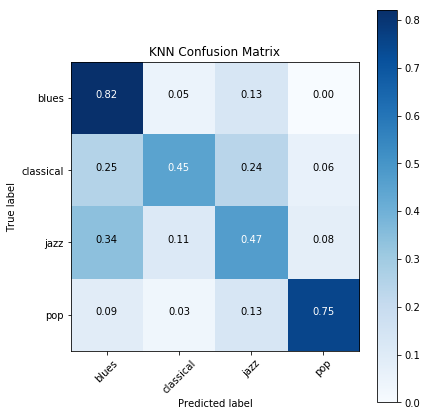

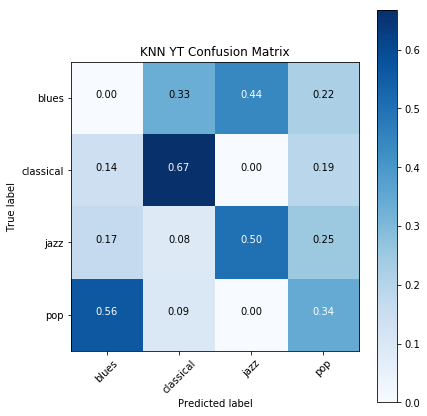

In [69]:
%%time
kf = KFold(n_splits=5)

guess = []
actual = []

yt_guess = []
yt_actual = []

for trainIndex, testIndex in kf.split(all_input_shuffledData):
    X_train, X_test = all_input_shuffledData[trainIndex], all_input_shuffledData[testIndex]
    y_train, y_test = all_input_shuffledClass[trainIndex], all_input_shuffledClass[testIndex]
    
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train,y_train)
    
    actual.extend(y_test)
    guess.extend(knn.predict(X_test))

    yt_guess.extend(knn.predict(yt_data))
    yt_actual.extend(yt_class)

coeff = confusion_matrix(actual, guess)

plot_confusion_matrix(coeff, classes=music_type_str, normalize=True,
                      title='KNN Confusion Matrix')
print("KNN Score: ", accuracy_score(actual, guess))


coeff = confusion_matrix(yt_guess, yt_actual)
plot_confusion_matrix(coeff, classes=music_type_str, normalize=True,
                      title='KNN YT Confusion Matrix')
print("KNN Youtube Score: ", accuracy_score(yt_guess, yt_actual))


## SVM

SVM Score:  0.835
SVM Youtube Score:  0.5578947368421052
CPU times: user 2.41 s, sys: 150 ms, total: 2.56 s
Wall time: 2.36 s


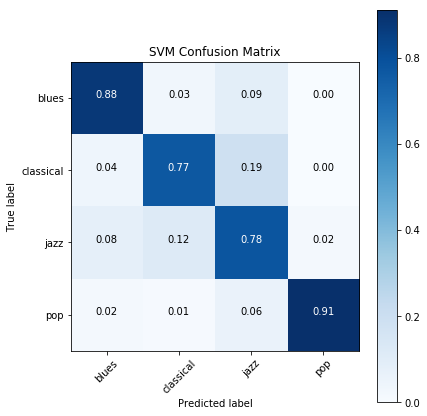

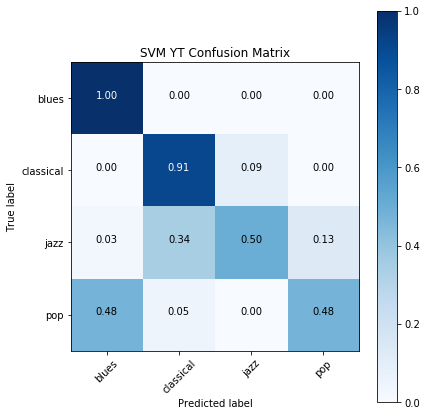

In [73]:
%%time
kf = KFold(n_splits=5)

guess = []
actual = []

yt_guess = []
yt_actual = []

for trainIndex, testIndex in kf.split(all_input_shuffledData):
    X_train, X_test = all_input_shuffledData[trainIndex], all_input_shuffledData[testIndex]
    y_train, y_test = all_input_shuffledClass[trainIndex], all_input_shuffledClass[testIndex]
    
    svm1 = svm.LinearSVC(C=10, loss='squared_hinge', penalty='l2', tol=0.00001)
    svm1.fit(X_train,y_train)
    
    actual.extend(y_test)
    guess.extend(svm1.predict(X_test))

    yt_guess.extend(svm1.predict(yt_data))
    yt_actual.extend(yt_class)

coeff = confusion_matrix(actual, guess)
plot_confusion_matrix(coeff, classes=music_type_str, normalize=True,
                      title='SVM Confusion Matrix')
print("SVM Score: ", accuracy_score(actual, guess))


coeff = confusion_matrix(yt_guess, yt_actual)
plot_confusion_matrix(coeff, classes=music_type_str, normalize=True,
                      title='SVM YT Confusion Matrix')
print("SVM Youtube Score: ", accuracy_score(yt_guess, yt_actual))

## Decision Tree

Decision Tree Score:  0.715
Decision Youtube Score:  0.6526315789473685
CPU times: user 545 ms, sys: 193 ms, total: 738 ms
Wall time: 517 ms


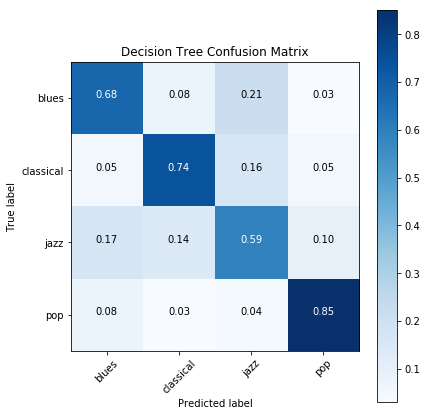

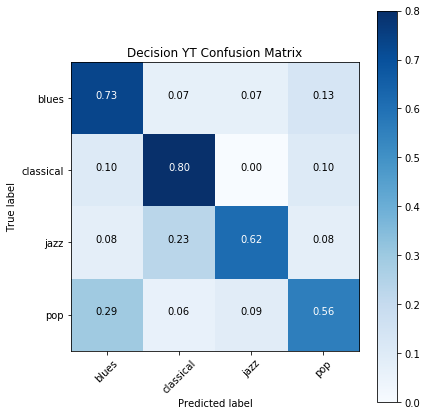

In [74]:
%%time
kf = KFold(n_splits=5)

guess = []
actual = []

yt_guess = []
yt_actual = []

for trainIndex, testIndex in kf.split(all_input_data):
    X_train, X_test = all_input_shuffledData[trainIndex], all_input_shuffledData[testIndex]
    y_train, y_test = all_input_shuffledClass[trainIndex], all_input_shuffledClass[testIndex]
    
    dt = DecisionTreeClassifier()
    dt.fit(X_train, y_train)
    
    actual.extend(y_test)
    guess.extend(dt.predict(X_test))
    
    yt_guess.extend(dt.predict(yt_data))
    yt_actual.extend(yt_class)
    
coeff = confusion_matrix(actual, guess)
plot_confusion_matrix(coeff, classes=music_type_str, normalize=True,
                      title='Decision Tree Confusion Matrix')        
print("Decision Tree Score: ", accuracy_score(actual, guess))


coeff = confusion_matrix(yt_guess, yt_actual)
plot_confusion_matrix(coeff, classes=music_type_str, normalize=True,
                      title='Decision YT Confusion Matrix')
print("Decision Youtube Score: ", accuracy_score(yt_guess, yt_actual))


## XGBoost - Ensemble Boosting

XGBoost Accuracy Score: 0.8675
XGBoost Youtube Score:  0.7473684210526316
CPU times: user 1min 32s, sys: 449 ms, total: 1min 33s
Wall time: 26.6 s


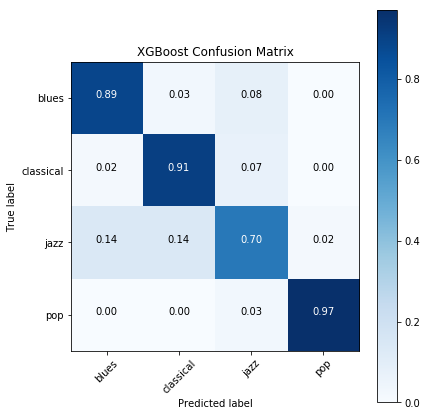

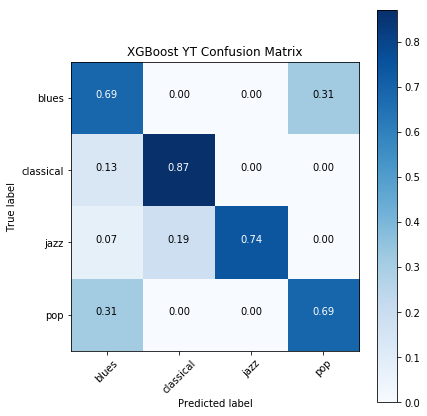

In [71]:
%%time
kf = KFold(n_splits=5)

guess = []
actual = []

yt_guess = []
yt_actual = []

for trainIndex, testIndex in kf.split(all_input_data):
    X_train, X_test = all_input_shuffledData[trainIndex], all_input_shuffledData[testIndex]
    y_train, y_test = all_input_shuffledClass[trainIndex], all_input_shuffledClass[testIndex]
    
    xgb_params = {
        'eta': 0.05,
        'max_depth': 5,
        'subsample': 0.9,
        'objective': 'multi:softmax',
        'silent': 1,
        'colsample_bytree': 0.9,
        'num_class':10
    }

    dtrain = xgb.DMatrix(X_train, y_train)
    dtest = xgb.DMatrix(X_test, y_test)
    
    model = xgb.train(xgb_params, dtrain, num_boost_round = 240)
    
    actual.extend(y_test)
    guess.extend(model.predict(dtest))
    
    d_yt = xgb.DMatrix(yt_data, yt_class)
    yt_guess.extend(model.predict(d_yt))
    yt_actual.extend(yt_class)
    
coeff = confusion_matrix(actual, guess)
plot_confusion_matrix(coeff, classes=music_type_str, normalize=True,
                      title='XGBoost Confusion Matrix')
print('XGBoost Accuracy Score:',accuracy_score(actual, guess))

coeff = confusion_matrix(yt_guess, yt_actual)
plot_confusion_matrix(coeff, classes=music_type_str, normalize=True,
                      title='XGBoost YT Confusion Matrix')
print("XGBoost Youtube Score: ", accuracy_score(yt_guess, yt_actual))


### KMeans

KMeans Score:  0.935
KMeans Youtube Score:  0.8947368421052632
CPU times: user 8.33 s, sys: 209 ms, total: 8.54 s
Wall time: 8.3 s


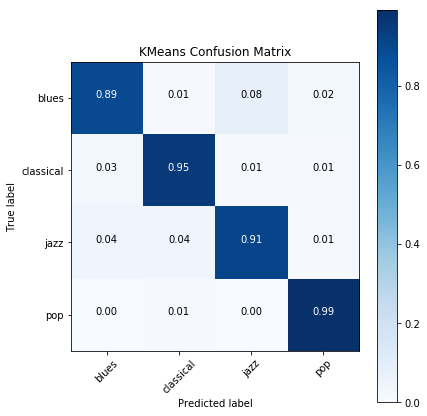

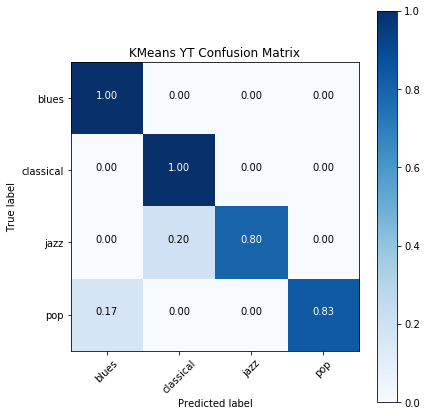

In [72]:
%%time

k=10
kf = KFold(n_splits=5)

guess = []
actual = []

yt_guess = []
yt_actual = []

for trainIndex, testIndex in kf.split(all_input_shuffledData):
    X_train, X_test = all_input_shuffledData[trainIndex], all_input_shuffledData[testIndex]
    y_train, y_test = all_input_shuffledClass[trainIndex], all_input_shuffledClass[testIndex]
    
    clusterer = KMeansClusterer(k, euclidean_distance, repeats=10)
    clusters = clusterer.cluster(X_train, True)
    
    actual.extend(y_test)
    guess.extend(dt.predict(X_test))
    
    yt_guess.extend(dt.predict(yt_data))
    yt_actual.extend(yt_class)
    
coeff = confusion_matrix(actual, guess)
plot_confusion_matrix(coeff, classes=music_type_str, normalize=True,
                      title='KMeans Confusion Matrix')        
print("KMeans Score: ", accuracy_score(actual, guess))

coeff = confusion_matrix(yt_guess, yt_actual)
plot_confusion_matrix(coeff, classes=music_type_str, normalize=True,
                      title='KMeans YT Confusion Matrix')
print("KMeans Youtube Score: ", accuracy_score(yt_guess, yt_actual))

## Random Forest - Ensemble Boosting

Random Forest Score:  0.6925
Random Forest Youtube Score:  0.8947368421052632
CPU times: user 343 ms, sys: 181 ms, total: 524 ms
Wall time: 305 ms


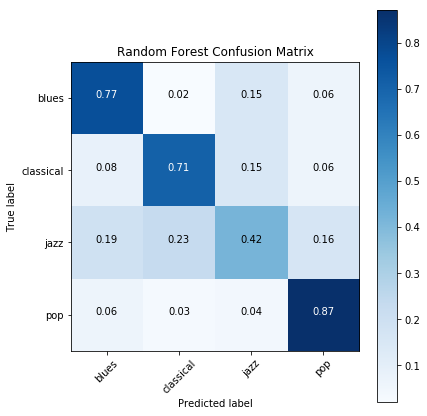

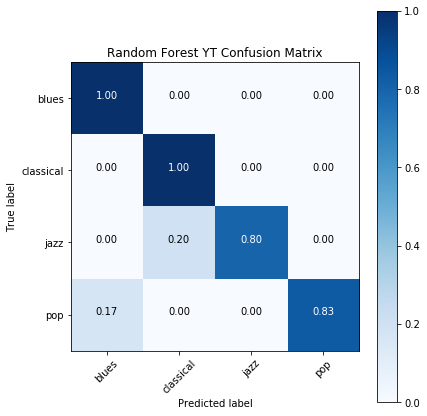

In [77]:
%%time
kf = KFold(n_splits=5)

guess = []
actual = []

yt_guess = []
yt_actual = []

for trainIndex, testIndex in kf.split(all_input_shuffledData):
    X_train, X_test = all_input_shuffledData[trainIndex], all_input_shuffledData[testIndex]
    y_train, y_test = all_input_shuffledClass[trainIndex], all_input_shuffledClass[testIndex]
    
    clf = RandomForestClassifier(max_depth=2, random_state=0)
    clf.fit(X_train, y_train)
 
    actual.extend(y_test)
    guess.extend(clf.predict(X_test))
    
    yt_guess.extend(dt.predict(yt_data))
    yt_actual.extend(yt_class)
    
coeff = confusion_matrix(actual, guess)
plot_confusion_matrix(coeff, classes=music_type_str, normalize=True,
                      title='Random Forest Confusion Matrix')        
print("Random Forest Score: ", accuracy_score(actual, guess))

coeff = confusion_matrix(yt_guess, yt_actual)
plot_confusion_matrix(coeff, classes=music_type_str, normalize=True,
                      title='Random Forest YT Confusion Matrix')
print("Random Forest Youtube Score: ", accuracy_score(yt_guess, yt_actual))